# NLP & W2VEC

In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from pythainlp.tokenize import THAI2FIT_TOKENIZER # ใช้ในการตัดคำ
from pythainlp.corpus import common # ใช้ลบคำที่ไม่ใช้ออก

from sklearn import preprocessing

# Word2Vec
from pythainlp.word_vector import WordVector
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# AI
from sklearn.model_selection import train_test_split # split data set
from sklearn.metrics import accuracy_score, classification_report # report train & test result

# AI Models
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Tunning
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from skopt.plots import plot_objective, plot_histogram

# Saving Intelligence
from joblib import dump, load


In [43]:
data = pd.read_csv("./data/data1668154807.csv")
data = data[['message', 'category']]

In [44]:
data.head()

,message,category
0,ทำเองทุกข้อนะ,A
1,แต่เราก็ลง cloud ยังไม่ได้ปะ,A
2,พวกที่ต้องการสหกิจ,A
3,ใช่ที่ยิมส่งไปอันแรกเป็นแบบทดสอบ อันที่2 แบบปร...,A
4,อันที่ยิมส่งมาป่าว,A


### Data Features and Values

In [45]:
category_list = data['category'].unique()
category_list

array(['A', 'C', 'Q', 'S', 'T'], dtype=object)

In [46]:
def clean_data(data):
    # sort data by category
    data = data.sort_values(by=['category'])

    data = data.reset_index()
    data = data[['message', 'category']]

    return data

In [47]:
data = clean_data(data= data)

In [48]:
data.shape

(13666, 2)

In [49]:
data.dtypes

message     object
category    object
dtype: object

In [50]:
data.isnull().any()

message     False
category    False
dtype: bool

### Countplot of target Variable(Category)

In [51]:
def plot_count_graph():
    count_graph = sns.countplot(data.category)
    count_list = []

    for p in count_graph.patches:
        height = p.get_height()
        count_list.append(height)
        count_graph.annotate('{:.1f}'.format(height), (p.get_x()+0.25, height+0.01))

    plt.show()

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


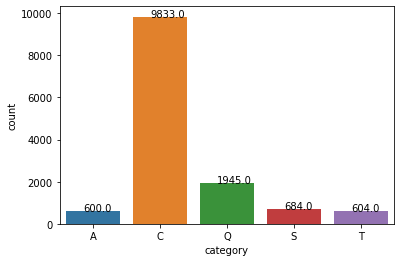

In [52]:
plot_count_graph()

### Balancing Category

In [53]:
df_list = []
for category in category_list:
    df_list.append(data.query(f"category == '{category}'").sample(
        n=600,
        replace=False, #True if numbers of sample higher than minimum numbers of category
        random_state=18, 
        )
    )

data = clean_data(data= pd.concat(df_list))

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


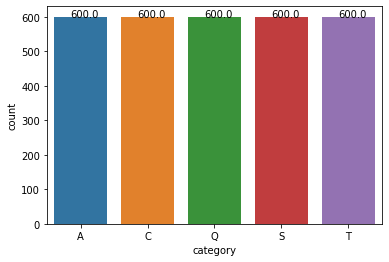

In [54]:
plot_count_graph()

In [55]:
data['message_length'] = data['message'].str.len()
print(data['message_length'])

0       12
1       20
2       26
3       26
4       53
        ..
2995    23
2996    45
2997    37
2998    11
2999    22
Name: message_length, Length: 3000, dtype: int64


### Words Distribution Plot

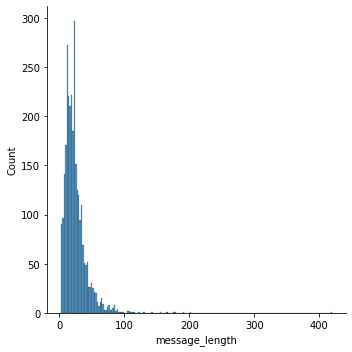

In [56]:
sns.displot(data['message_length']).set_titles('message_length')

### Count Words

In [57]:
def count_words(category=''):
    word_list = set()
    if(category != ''):
        sub_frame = data[data['category']==category]
    else:
        sub_frame = data

    for text in sub_frame['message']:
        
        text = text.lower().replace('\n', ' ').replace('\r', '').strip()
        text = re.findall(r"[\u0E00-\u0E7Fa-zA-Z']+", text)
        text = ' '.join(text)

        word_tokens = THAI2FIT_TOKENIZER.word_tokenize(text)
        filtered_sentence = set([w for w in word_tokens])

        word_list.update(filtered_sentence)

    return len(word_list)

In [58]:
words_category = []
for category in category_list:
    words_category.append(count_words(category))

words_category

[998, 946, 891, 916, 921]

In [59]:
print('Total Word:')
print(count_words())

Total Word:
2441


<AxesSubplot:xlabel='category', ylabel='words_count'>

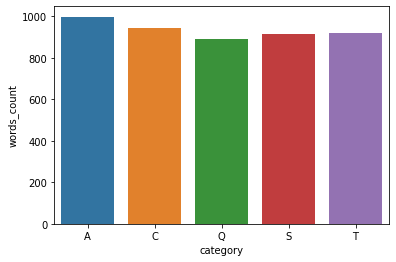

In [60]:
words_count = {'category': category_list, 'words_count': words_category}
w_count_data = pd.DataFrame(words_count)
sns.barplot(x= 'category', y='words_count', data=w_count_data)

### Word Cloud

In [61]:
def create_wordcloud(words):
    wordcloud = WordCloud(font_path='THSarabun.ttf', # path ที่ตั้ง Font
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(THAI2FIT_TOKENIZER.word_tokenize(words)))
    plt.figure(figsize=[10, 7])
    plt.imshow(wordcloud, interpolation= "bilinear")
    plt.axis('off')
    plt.show()

In [62]:
def check_wordcloud(category):
    subset = data[data.category==category]
    text = subset.message.values
    words = ''.join(text)
    create_wordcloud(words)

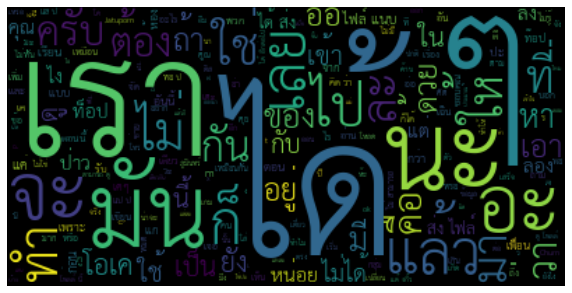

In [63]:
check_wordcloud('C')

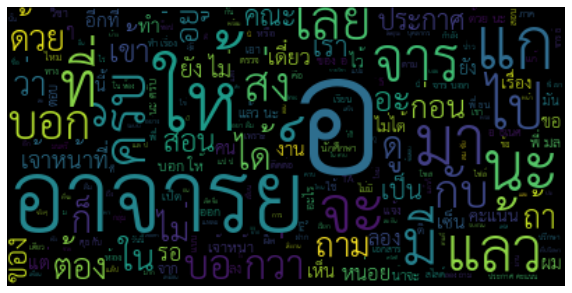

In [64]:
check_wordcloud('T')

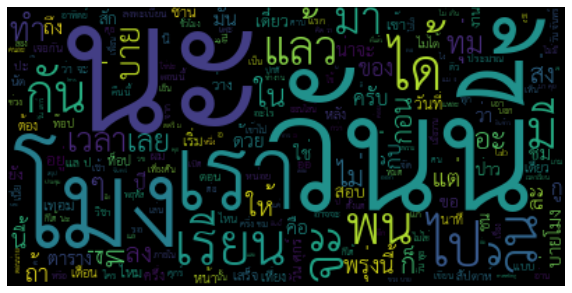

In [65]:
check_wordcloud('S')

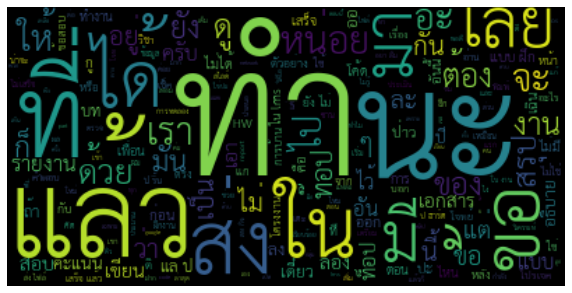

In [66]:
check_wordcloud('A')

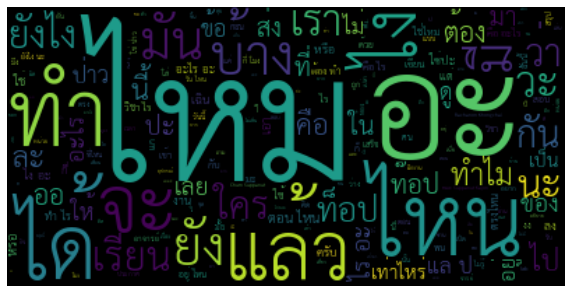

In [67]:
check_wordcloud('Q')

### Label Encoding

In [68]:
label_encoder = preprocessing.LabelEncoder()
data['category_target'] = label_encoder.fit_transform(data['category'])

In [69]:
temp_data = data[['category', 'category_target']].drop_duplicates()
print(temp_data)

     category  category_target
0           A                0
600         C                1
1200        Q                2
1800        S                3
2400        T                4


In [70]:
# keep category target in json
json_classes = temp_data.to_json(orient="records")

# Writing to .json
with open("classes.json", "w") as outfile:
    outfile.write(json_classes)


   


In [71]:
# Opening JSON file
with open('classes.json', 'r') as openfile:
    # Reading from json file
    temp_json = json.load(openfile)
    print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [72]:
temp_json.sort(key=lambda item : item['category_target'])
print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [73]:
classes_list = [ item['category'] for item in temp_json]
print(classes_list)

['A', 'C', 'Q', 'S', 'T']


### Word2Vec

In [74]:
w2v_thai = WordVector()

In [75]:

word2vec = [w2v_thai.sentence_vectorizer(data['message'][i]) 
            for i in range(0,len(data['message']))]

In [76]:
X = np.array(word2vec).tolist()

data['word2vec'] = X
data_reshape = np.reshape(X, (-1, 300))

In [77]:
print(data_reshape.shape)

(3000, 300)


In [78]:
data.head()

,message,category,message_length,category_target,word2vec
0,คะแนนnetwork,A,12,0,"[[-0.26684350334107876, 0.24634199030697346, 0..."
1,เห็นว่าคะแนนศาสออกละ,A,20,0,"[[-0.16997399864097437, -0.011077666034301123,..."
2,ก็มีอันที่ประเมินนะ คิดว่า,A,26,0,"[[-0.054493777039978236, -0.26752699952986503,..."
3,เราจะเขียนเขียนวิเคราะห์อะ,A,26,0,"[[-0.12925466522574425, -0.10246449833114941, ..."
4,น่าจะได้นะ มันมีช่องเอ้าพุท cmos อยุ่มั้ง ถ้าจ...,A,53,0,"[[-0.13175639028971395, -0.057020891561276384,..."


# AI MODEL

### Split the data in Training and Testing

In [79]:
data_temp = [ x for x in data['word2vec']]
data_reshape = np.reshape(data_temp, (-1, 300))
data_reshape.shape


(3000, 300)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(data_reshape,
                                                    data['category_target'],
                                                    random_state=18,
                                                    test_size = 0.2,
                                                    shuffle=True
                                                    )

In [92]:
print(X_train.shape)
print(y_train.shape)

(2400, 300)
(2400,)


In [93]:
print(X_test.shape)
print(y_test.shape)

(600, 300)
(600,)


### Models Predictions

In [104]:
# RandomForest Model
rf_model = RandomForestClassifier(
    # n_estimators= 1300,
    # max_depth= 180,
    # min_samples_split= 2,
    # bootstrap= False,
    # criterion= 'entropy',
    )
rf_model.fit(X_train, y_train)

accuracy_predictions = rf_model.predict(X_train)
print('Validation', accuracy_score(y_train, accuracy_predictions))

model_predictions = rf_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))

print(classification_report(y_test, model_predictions))

Validation 0.99875
Accuracy 0.6433333333333333
              precision    recall  f1-score   support

           0       0.53      0.67      0.59       112
           1       0.69      0.48      0.57       129
           2       0.59      0.63      0.61       110
           3       0.68      0.62      0.65       116
           4       0.74      0.81      0.77       133

    accuracy                           0.64       600
   macro avg       0.65      0.64      0.64       600
weighted avg       0.65      0.64      0.64       600



### Save AI Model

In [108]:
# dump(rf_model, './models/rf_model.joblib')

['./models/rf_model.joblib']

### BayesSearch Hyperparameter Tunning

<!-- Suggest Config RandomForest example
{'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
        2378, 2585, 2792, 3000]),
 'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
 'min_samples_split': [1, 2, 5, 10, 15, 20, 30],
 'min_samples_leaf': [1, 2, 3, 4],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy']} -->

In [96]:
# model = RandomForestClassifier(
#     bootstrap=False,
#     # criterion='entropy',
#     # min_samples_split=2,
#     )
# opt = BayesSearchCV(
#     model,
#     {
#         'n_estimators': Integer(800, 1300),
#         # 'max_depth': Integer(100, 200),
#         'min_samples_split': Integer(2, 30),
#         'min_samples_leaf': Integer(1, 10),
#         'bootstrap': Categorical(['True', 'False']),
#         'criterion': Categorical(['gini', 'entropy']),
#     }
#     , cv=3
#     , verbose=1
#     , random_state=0
#     , n_iter= 100
# )
# opt.fit(X_train, y_train)

In [97]:
# print(opt.best_score_)
# print(opt.best_params_)

In [98]:
# plot_objective(opt.optimizer_results_[0],
#                    dimensions=[
#                     'bootstrap',
#                     'criterion',
#                     'max_depth',
#                     'min_samples_leaf',
#                     'min_samples_split',
#                     'n_estimator',
#                     # 'random_state',
#                     ],
#                    n_minimum_search=int(1e8))
# plt.show()

# Use Case with Modules


In [109]:
from project_module.message_classifier import MessageClassifier
message_classifier = MessageClassifier()

In [110]:
message_classifier.load_model(model_path='./models/rf_model.joblib', json_classes_path='./classes.json')

In [111]:
print(message_classifier.classify(text_input='มีแบบฝึกต้องส่งนะ'))

A
